## Week 2 - Implementing Grovers Algorithm for 4 Lights Out Problems Simultaneously

In [1]:
import numpy as np
from sympy import Matrix
from qiskit import IBMQ, QuantumCircuit, Aer, execute, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

In [2]:
def qRam4LightsOut(qc, DataQ, AdrQ, AnsQ, FlagQ, CountQ, CheckQ, Out, lightsout4):
    for adr in range(4):
        if adr < 2:
            qc.x(AdrQ[0])
        if (adr % 2) == 0:
            qc.x(AdrQ[1])
        for i in range(9):
            if lightsout4[adr][i] == 1:
                qc.ccx(AdrQ[0], AdrQ[1], DataQ[i])
        if adr < 2:
            qc.x(AdrQ[0])
        if (adr % 2) == 0:
            qc.x(AdrQ[1])

In [10]:
def Oracle4LightsOut(qc, DataQ, AdrQ, AnsQ, FlagQ, CountQ, CheckQ, Out, lightsout4):
    matrixA = np.array([[1,1,0,1,0,0,0,0,0],[1,1,1,0,1,0,0,0,0],[0,1,1,0,0,1,0,0,0],[1,0,0,1,1,0,1,0,0],[0,1,0,1,1,1,0,1,0],[0,0,1,0,1,1,0,0,1],[0,0,0,1,0,0,1,1,0],[0,0,0,0,1,0,1,1,1],[0,0,0,0,0,1,0,1,1]])

    for i in range(9):
        qc.cx(AnsQ[i], CountQ[0])
        qc.x(CountQ)
        qc.mcx([AnsQ[i], CountQ[0]], CountQ[1])
        qc.mcx([AnsQ[i], CountQ[0], CountQ[1]], CountQ[2])
        qc.mcx([AnsQ[i], CountQ[0], CountQ[1], CountQ[2]], CountQ[3])
        qc.x(CountQ)
    qc.x(CheckQ[0])
    qc.cx(CountQ[2], CheckQ[0])
    qc.cx(CountQ[3], CheckQ[0])
    qc.mct([CountQ[2],CountQ[3]], CheckQ[0])

    for j in range(9):
        for i in range(9):
            if matrixA[j,i]==1:
                qc.cx(AnsQ[j], DataQ[i])
    qc.x(DataQ)

    qc.mct([CheckQ[0], DataQ[0], DataQ[1], DataQ[2], DataQ[3], DataQ[4], DataQ[5], DataQ[6], DataQ[7], DataQ[8]], FlagQ[0])

    qc.x(DataQ)
    for j in range(9):
        for i in range(9):
            if matrixA[j,i]==1:
                qc.cx(AnsQ[j], DataQ[i])

    qc.x(CheckQ[0])
    qc.cx(CountQ[2], CheckQ[0])
    qc.cx(CountQ[3], CheckQ[0])
    qc.mct([CountQ[2],CountQ[3]], CheckQ[0])
    for i in range(9):
        qc.x(CountQ)
        qc.mct([AnsQ[i], CountQ[0], CountQ[1], CountQ[2]], CountQ[3])
        qc.mct([AnsQ[i], CountQ[0], CountQ[1]], CountQ[2])
        qc.mct([AnsQ[i], CountQ[0]], CountQ[1])
        qc.x(CountQ)
        qc.cx(AnsQ[i], CountQ[0])
    qc.x(CountQ)

In [4]:
def Diffuser(n):
    qc = QuantumCircuit(n)
    for qubit in range(n):
        qc.h(qubit)
    for qubit in range(n):
        qc.x(qubit)
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)
    for qubit in range(n):
        qc.x(qubit)
    for qubit in range(n):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return qc

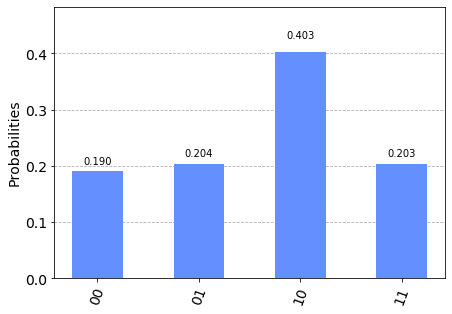

In [21]:
lightsout4 = [[1, 1, 1, 0, 0, 0, 1, 0, 0],[1, 0, 1, 0, 0, 0, 1, 1, 0],[1, 0, 1, 1, 1, 1, 0, 0, 1],[1, 0, 0, 0, 0, 0, 1, 0, 0]] 

DataQ = QuantumRegister(9, name='data')
AdrQ = QuantumRegister(2, name='adr')
AnsQ = QuantumRegister(9, name='ans')
FlagQ = QuantumRegister(1, name='flag')
CountQ = QuantumRegister(4, name='count')
CheckQ = QuantumRegister(1, name='check')
Out = ClassicalRegister(2, name='out')
qc = QuantumCircuit(DataQ, AdrQ, AnsQ, FlagQ, CountQ, CheckQ, Out)

qc.x(FlagQ)
qc.h(FlagQ)

qc.h(AdrQ)
qc.h(AnsQ)

for i in range(10):
    qRam4LightsOut(qc, DataQ, AdrQ, AnsQ, FlagQ, CountQ, CheckQ, Out, lightsout4)
    Oracle4LightsOut(qc, DataQ, AdrQ, AnsQ, FlagQ, CountQ, CheckQ, Out, lightsout4)
    qRam4LightsOut(qc, DataQ, AdrQ, AnsQ, FlagQ, CountQ, CheckQ, Out, lightsout4)
    l = []
    for i in range(2):
        l.append(AdrQ[i])
    for i in range(9):
        l.append(AnsQ[i])
    qc.append(Diffuser(11), l)

qc.measure(AdrQ, Out[0:2])
qc = qc.reverse_bits()
result = execute(qc, backend, shots = 8192).result()
counts = result.get_counts()
plot_histogram(counts)